#Image Classification on Fashion MNIST dataset

IMPORT PACKAGES


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from keras.regularizers import L1L2
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
import os
import time

set_seed(1)
np.random.seed(42)

Using TensorFlow backend.


IMPORT DATA

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (fashion_mnist.load_data()) #The dataset is already divede in test and training

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

EXPLORE DATA I


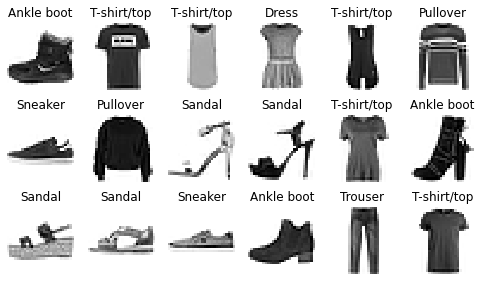

In [ ]:
n_rows = 3
n_cols = 6
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train_full[index]])
plt.show()

EXPLORE DATA II


In [ ]:
print("--------------------------")
print("Dimensions of Train Set")
print("Dimension of the training set = ",np.shape(X_train_full))
print("There are", np.shape(X_train_full)[0], "images where each image is", np.shape(X_train_full)[1:], "in size")
print("There are", np.shape(np.unique(y_train_full))[0], "unique image labels;", "example of ten labels:", y_train_full[1:10])
print("--------------------------")
print("Dimensions of Test Set")
print("Dimension of the test set  = ",np.shape(X_test))
print("Number of test set = ", np.shape(y_test)[0])
print("--------------------------")

--------------------------
Dimensions of Train Set
Dimension of the training set =  (60000, 28, 28)
There are 60000 images where each image is (28, 28) in size
There are 10 unique image labels; example of ten labels: [0 0 3 0 2 7 2 5 5]
--------------------------
Dimensions of Test Set
Dimension of the test set  =  (10000, 28, 28)
Number of test set =  10000
--------------------------


NORMALIZATION (not standardization)

In [ ]:
# Normalize the data
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Division of data in an equal manner (train and validation set)
sss = StratifiedShuffleSplit(1, test_size = 5000, random_state=42)
for train_index, test_index in sss.split(X_train_full, y_train_full):
    X_valid, X_train = X_train_full[test_index,:], X_train_full[train_index,:] 
    y_valid, y_train = y_train_full[test_index], y_train_full[train_index]

FLATTENING IMAGES INTO A SINGLE DIMENSION

In [ ]:
# For the grid search 
X_train_full_vector =  X_train_full.reshape(X_train_full.shape[0], 784) #28*28 
# For the trials and errors model
X_train_vector = X_train.reshape(X_train.shape[0], 784) #28*28
X_valid_vector = X_valid.reshape(X_valid.shape[0], 784) #28*28

X_test_vector = X_test.reshape(X_test.shape[0], 784)

print('The flattened train_full image dataset has shape:', X_train_full_vector.shape)
print('The flattened train image dataset has shape:', X_train_vector.shape)
print('The flattened validation image dataset has shape:', X_valid_vector.shape)
print('The flattened test image dataset has shape:', X_test_vector.shape)

The flattened train_full image dataset has shape: (60000, 784)
The flattened train image dataset has shape: (55000, 784)
The flattened validation image dataset has shape: (5000, 784)
The flattened test image dataset has shape: (10000, 784)


# Logistic Regression Model

In [ ]:
# To plot the results
def plot_learning_loss(history):
    pd.DataFrame(history.history).iloc[:,[0,2]].plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()

In [ ]:
# To fit the model you need to modify the dimensions of the output

# Dimensions of y
print("Dimensions of y:", y_train_full.shape, y_train.shape, y_valid.shape, y_test.shape)

# New dimensions:

# For the grid search (one-hot encode of y)
y_train_full_cat = to_categorical(y_train_full)
# For the trials and errors model
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

y_test_cat = to_categorical(y_test)

print("New dimensions:",y_train_full_cat.shape, y_train_cat.shape, y_valid_cat.shape, y_test_cat.shape)

Dimensions of y: (60000,) (55000,) (5000,) (10000,)
New dimensions: (60000, 10) (55000, 10) (5000, 10) (10000, 10)


TRIALS AND ERRORS MODEL

This model allows the search of the appropriate parameters on which to define the range of possible values of the hyperparameters used in the grid search.

For example:

making several attempts it has been seen that the range of possible values of the learning rate is between 0.001 and 0.01. These values were considered for the choice of the "learning rate" hyperparameter values in the grid search. 

In [ ]:
output_dim  = 10     # num_classes
input_dim = 784      # 28*28 

model = Sequential() 
model.add(Dense(output_dim, input_dim=input_dim, activation='softmax', kernel_regularizer=L1L2(l1=0.0001, l2=0)))

model.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy']) 

Model fitting on the training set and accuracy calculation on validation set 

In [ ]:
history = model.fit(X_train_vector, y_train_cat, batch_size=2500, epochs=125, validation_data=(X_valid_vector, y_valid_cat), verbose = 0) 

###Trials and errors model
Model evaluation (loss and test accuracy) and comparison between training loss and validation loss (plot)

Loss score: 0.5058198223590851
Test accuracy: 0.8389000296592712


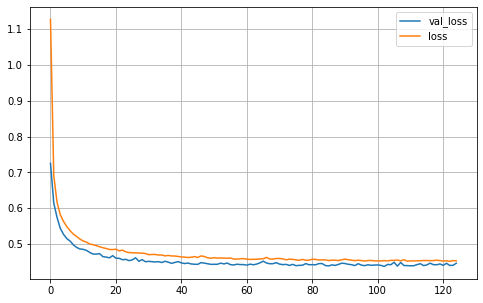

In [ ]:
score = model.evaluate(X_test_vector, y_test_cat, verbose=0) 
print('Loss score:', score[0]) 
print('Test accuracy:', score[1])
plot_learning_loss(history)

##GRID SEARCH

Choice of "learning rate", "L1 regularizer", "optimizer" hyperparameters.

Logistic regression model implemented with a simple nn. Use of a grid search to compare the possible combinations of hyperparameter values.

To evaluate the performance of each combination of parameters (model) a 5-fold cross-validation was carried out:
the full train was divided into 5 folds and iteratively each was used as a validation set for the other four (trains). From this procedure 5 errors are obtained whose average is calculated.

Finally, the errors of all combinations of parameters (models) are compared and the one with the lowest error is considered. The best combination of parameters is thus obtained.

In [ ]:
param_distribs = {  
    "learning_rate": [0.001, 0.005, 0.01],
    "kernel_reg_L1": [0.00001, 0.0001, 0.0005, 0.001],
    "opt": ["Adam", "Adamax", "SGD"]
}

In [ ]:
def build_model(kernel_reg_L1, learning_rate, opt):
    model = Sequential() 
    model.add(Dense(output_dim=10, input_dim=784, activation='softmax', kernel_regularizer=regularizers.l1(kernel_reg_L1)))

    if opt == "Adam":
      optimizer = keras.optimizers.Adam(lr= learning_rate)
    elif opt == "Adamax":
      optimizer = keras.optimizers.Adamax(lr= learning_rate)
    elif opt == "SGD":
      optimizer = keras.optimizers.SGD(lr= learning_rate)


    model.compile(optimizer=optimizer,  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

In [ ]:
keras_model = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

grid_search = GridSearchCV(keras_model, param_distribs)
grid_search.fit(X_train_full_vector, y_train_full_cat, epochs=100, batch_size = 2048, verbose = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=784, activation="softmax", kernel_regularizer=<tensorflo..., units=10)`
  This is separate from the ipykernel package so we can avoid doing imports until


12000/12000 [==============================] - 0s 18us/step


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7efcb72a1438>,
             iid='deprecated', n_jobs=None,
             param_grid={'kernel_reg_L1': [1e-05, 0.0001, 0.0005, 0.001],
                         'learning_rate': [0.001, 0.005, 0.01],
                         'opt': ['Adam', 'Adamax', 'SGD']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Grid search results: best parameters


In [ ]:
print(grid_search.best_params_)
model = grid_search.best_estimator_.model

{'kernel_reg_L1': 1e-05, 'learning_rate': 0.005, 'opt': 'Adamax'}


##Best Model


Best model obtained by grid search

In [ ]:
output_dim  = 10     # num_classes
input_dim = 784      # 28*28 

model = Sequential() 
model.add(Dense(output_dim, input_dim=input_dim, activation='softmax', kernel_regularizer=regularizers.l1(0.0005)))

model.compile(optimizer=keras.optimizers.Adamax(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy']) 

Model fitting on the whole train set

In [ ]:
history = model.fit(X_train_full_vector, y_train_full_cat, batch_size=2048, epochs=500, verbose = 0) 

###Best model
Model evaluation (loss and test accuracy) and comparison between training loss and validation loss (plot)

In [ ]:
score = model.evaluate(X_test_vector, y_test_cat, verbose=0) 
print('Loss score:', score[0]) 
print('Test accuracy:', score[1])

Loss score: 0.6280512223243714
Test accuracy: 0.8314999938011169


#K-NN Model


##Reduced Dataset for experiments

In [ ]:
X_train = X_train_full.reshape(X_train_full.shape[0], 784) #28*28
X_test = X_test.reshape(X_test.shape[0], 784)

In [ ]:
train_idx = np.random.randint(X_train.shape[0], size=6000)
test_idx = np.random.randint(X_test.shape[0], size=1000)
X_train = X_train[train_idx, :]
X_test = X_test[test_idx, :]
y_train = y_train_full[train_idx]
y_test = y_test[test_idx]

In [ ]:
print("--------------------------")
print("Dimensions of Train Set")
print("Dimension of the training set = ",np.shape(X_train))
print("There are", np.shape(X_train)[0], "images where each image is", np.shape(X_train)[1:], "in size")
print("There are", np.shape(np.unique(y_train))[0], "unique image labels;", "example of ten labels:", y_train[1:10])
print("--------------------------")
print("Dimensions of Test Set")
print("Dimension of the test set  = ",np.shape(X_test))
print("Number of test set = ", np.shape(y_test)[0])
print("--------------------------")

--------------------------
Dimensions of Train Set
Dimension of the training set =  (6000, 784)
There are 6000 images where each image is (784,) in size
There are 10 unique image labels; example of ten labels: [3 4 1 7 4 0 3 9 1]
--------------------------
Dimensions of Test Set
Dimension of the test set  =  (1000, 784)
Number of test set =  1000
--------------------------


##KNN using Sklearn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 10),
              'metric': ['euclidean', 'manhattan']}

#use gridsearch to test all values for n_neighbors and metric
start = time.time()
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X_train, y_train)

end = time.time()
knn_time = end - start

#grid search running time
print("Hyperparameter optimization in: {:0.2f} minute".format(knn_time/60.0))

Hyperparameter optimization in: 13.02 minute


In [ ]:
means = knn_gscv.cv_results_['mean_test_score']
stds = knn_gscv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, knn_gscv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.802 (+/-0.019) for {'metric': 'euclidean', 'n_neighbors': 1}
0.795 (+/-0.019) for {'metric': 'euclidean', 'n_neighbors': 2}
0.798 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 3}
0.802 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 4}
0.801 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 5}
0.801 (+/-0.017) for {'metric': 'euclidean', 'n_neighbors': 6}
0.798 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 7}
0.800 (+/-0.020) for {'metric': 'euclidean', 'n_neighbors': 8}
0.796 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 9}
0.811 (+/-0.022) for {'metric': 'manhattan', 'n_neighbors': 1}
0.804 (+/-0.020) for {'metric': 'manhattan', 'n_neighbors': 2}
0.813 (+/-0.005) for {'metric': 'manhattan', 'n_neighbors': 3}
0.807 (+/-0.013) for {'metric': 'manhattan', 'n_neighbors': 4}
0.806 (+/-0.008) for {'metric': 'manhattan', 'n_neighbors': 5}
0.804 (+/-0.015) for {'metric': 'manhattan', 'n_neighbors': 6}
0.805 (+/-0.016) for {'metric': 'manhattan', 'n_neighbo

In [ ]:
# check top performing metric and n_neighbors value
knn_gscv.best_params_

{'metric': 'manhattan', 'n_neighbors': 3}

In [ ]:
y_pred = knn_gscv.predict(X_test)
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.92      0.84       114
     Trouser       1.00      0.88      0.93       106
    Pullover       0.48      0.60      0.53        72
       Dress       0.98      0.91      0.94       112
        Coat       0.60      0.69      0.64        85
      Sandal       0.95      0.84      0.89       106
       Shirt       0.74      0.51      0.61       107
     Sneaker       0.92      0.94      0.93       129
         Bag       0.86      0.86      0.86        78
  Ankle boot       0.85      0.95      0.90        91

    accuracy                           0.82      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.83      0.82      0.82      1000



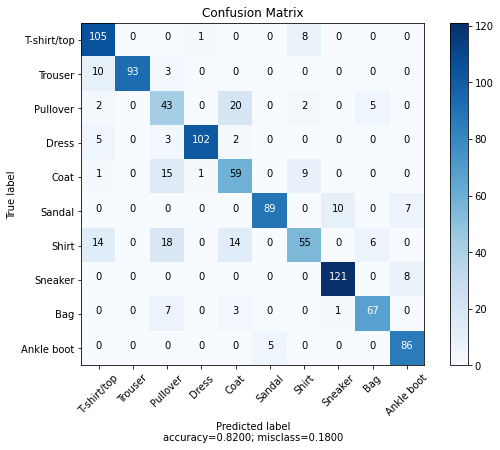

In [ ]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

knn_cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm=knn_cm, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

# CNN

### Loading Data



Here the Fashion Mnist dataset is loaded, then scaled such that every entry of the matrix images are in $[0,1]$.

At the end the full training set is divided into a train and validation set, which, thanks to the function $StratifiedShuffleSplit$ from the package $sklearn$ presents an equal amount of samples for each class and they are randomly taken within the full training set.

In the end it is implemented the Data Augmentation, foundamental for the training of the CNN both to increase its accuracy and lessen the tendency to overfit.

In [2]:
#Simple functions to display how the model trained and to have a general idea
#of its tendency to overfit

def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.title('loss')

def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'])
    plt.plot(history.epoch,history.history['val_accuracy'])
    plt.title('accuracy')

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data()) #The dataset is already divede in test and training..

#Normalize the data
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

sss = StratifiedShuffleSplit(1, test_size = 5000, random_state=42)
for train_index, test_index in sss.split(X_train_full, y_train_full):
    X_valid, X_train = X_train_full[test_index,:], X_train_full[train_index,:] 
    y_valid, y_train = y_train_full[test_index], y_train_full[train_index]

#copy of X_test useful for later utilisations
X_test_copy = X_test.copy()

#Add one dimension to manage the channel
X_train=tf.expand_dims(X_train, 3) 
X_valid=tf.expand_dims(X_valid, 3) 
X_test=tf.expand_dims(X_test,3)


#class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        )

datagen.fit(X_train)

## Simple CNN

Epoch 1/50
220/220 [==============================] - 8s 35ms/step - loss: 0.8116 - accuracy: 0.6968 - val_loss: 0.4586 - val_accuracy: 0.8386
Epoch 2/50
220/220 [==============================] - 7s 34ms/step - loss: 0.4787 - accuracy: 0.8247 - val_loss: 0.3630 - val_accuracy: 0.8668
Epoch 3/50
220/220 [==============================] - 7s 33ms/step - loss: 0.4023 - accuracy: 0.8533 - val_loss: 0.3115 - val_accuracy: 0.8822
Epoch 4/50
220/220 [==============================] - 7s 33ms/step - loss: 0.3663 - accuracy: 0.8648 - val_loss: 0.2833 - val_accuracy: 0.8974
Epoch 5/50
220/220 [==============================] - 7s 33ms/step - loss: 0.3415 - accuracy: 0.8748 - val_loss: 0.2639 - val_accuracy: 0.9008
Epoch 6/50
220/220 [==============================] - 7s 33ms/step - loss: 0.3204 - accuracy: 0.8827 - val_loss: 0.2459 - val_accuracy: 0.9096
Epoch 7/50
220/220 [==============================] - 7s 33ms/step - loss: 0.3063 - accuracy: 0.8884 - val_loss: 0.2415 - val_accuracy: 0.9104

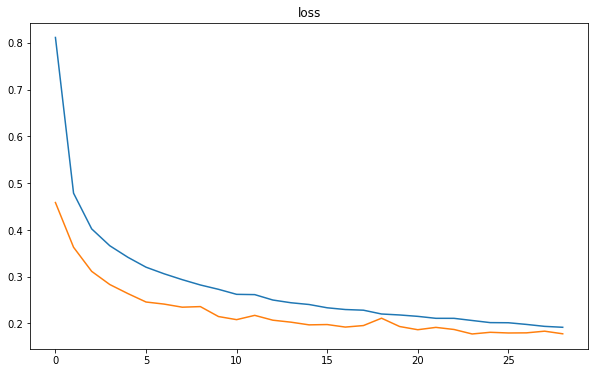

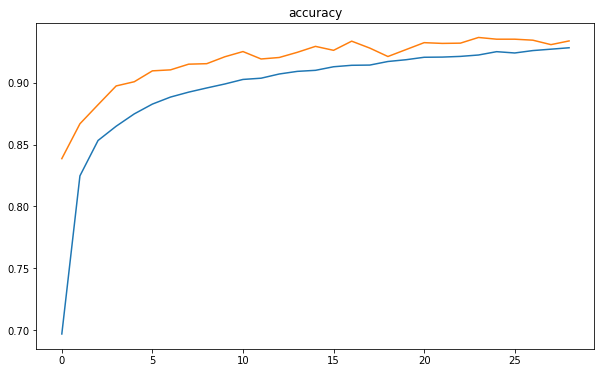

In [5]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters=64, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters=128, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters=256, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

history = model.fit(X_train, y_train, epochs=50, batch_size=250, validation_data=(X_valid, y_valid), callbacks=callbacks)

model.summary()

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [6]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

157/157 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.85      0.91      0.88      1000
           3       0.93      0.91      0.92      1000
           4       0.87      0.87      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.79      0.75      0.77      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [7]:
cnn_10 = tf.keras.models.load_model(
    'cnn_simple_9283.h5'
)

## CNN10

### Structure CNN10

Epoch 1/500
107/107 - 33s - loss: 0.5794 - accuracy: 0.7862 - val_loss: 2.7971 - val_accuracy: 0.1414
Epoch 2/500
107/107 - 30s - loss: 0.3649 - accuracy: 0.8635 - val_loss: 4.0080 - val_accuracy: 0.1000
Epoch 3/500
107/107 - 30s - loss: 0.3134 - accuracy: 0.8844 - val_loss: 3.4486 - val_accuracy: 0.2410
Epoch 4/500
107/107 - 30s - loss: 0.2850 - accuracy: 0.8941 - val_loss: 1.1484 - val_accuracy: 0.6300
Epoch 5/500
107/107 - 30s - loss: 0.2639 - accuracy: 0.9020 - val_loss: 0.5035 - val_accuracy: 0.8188
Epoch 6/500
107/107 - 30s - loss: 0.2469 - accuracy: 0.9085 - val_loss: 0.2548 - val_accuracy: 0.9080
Epoch 7/500
107/107 - 30s - loss: 0.2350 - accuracy: 0.9135 - val_loss: 0.1916 - val_accuracy: 0.9296
Epoch 8/500
107/107 - 30s - loss: 0.2205 - accuracy: 0.9183 - val_loss: 0.2152 - val_accuracy: 0.9158
Epoch 9/500
107/107 - 30s - loss: 0.2163 - accuracy: 0.9202 - val_loss: 0.2075 - val_accuracy: 0.9234
Epoch 10/500
107/107 - 30s - loss: 0.2064 - accuracy: 0.9238 - val_loss: 0.1974 - 

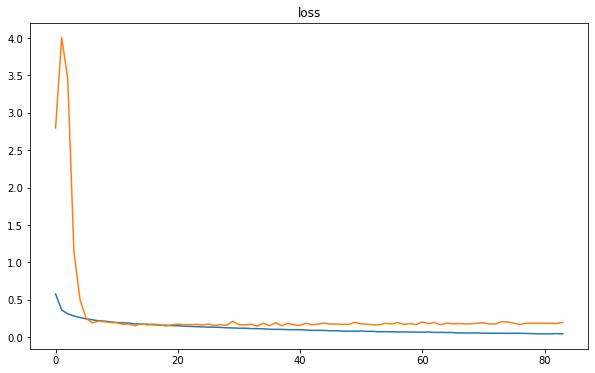

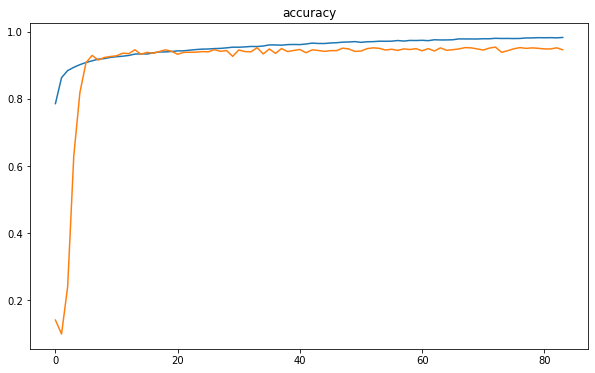

In [8]:
model = keras.models.Sequential([

    #First Block: 2 conv2d, 1 maxpool2d
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.2),

    #Second Block: 2 conv2d, 1 maxpool2d
    keras.layers.Conv2D(filters=128, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.2),

    #Third Block: 2 conv2d, 1 maxpool2d
    keras.layers.Conv2D(filters=512, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),

    #Fourth Block: 1 dense
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.2),

    #Fifth Block: 1 dense
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.2),

    #Sixth Block: 1 dense
    keras.layers.Dense(10, activation="softmax")
])



model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=50),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

#In this page it is not actually trained because the best performer was obtained
#in another notebook and saved in the 'my-mnist-model.h5' file


history = model.fit(datagen.flow(X_train, y_train, batch_size=512), shuffle=True, epochs=500, validation_data = (X_valid, y_valid), verbose = 2, steps_per_epoch=X_train.shape[0] // 512, callbacks=callbacks)

model.summary()

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

### CNN10 Load

In [9]:
cnn_10 = tf.keras.models.load_model(
    'cnn_10_9436.h5'
)

In [10]:
y_pred = cnn_10.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

scores = cnn_10.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_10.metrics_names[1], scores[1]*100))

157/157 [==============================] - 3s 16ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       1.00      0.99      0.99      1000
           2       0.92      0.90      0.91      1000
           3       0.94      0.94      0.94      1000
           4       0.92      0.92      0.92      1000
           5       0.99      0.99      0.99      1000
           6       0.83      0.84      0.83      1000
           7       0.97      0.98      0.98      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

313/313 - 3s - loss: 0.2245 - accuracy: 0.9436
accuracy: 94.36%


## Misclassification Exploration

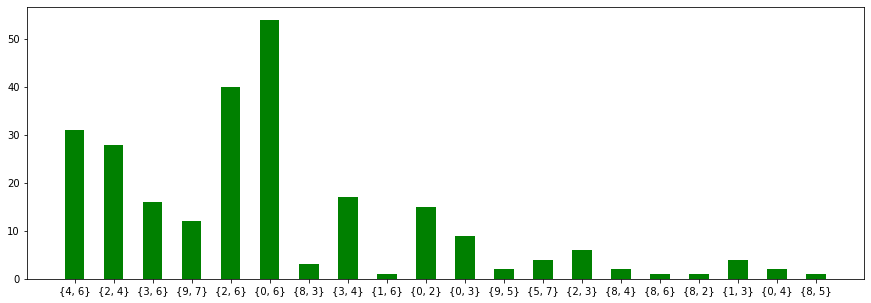

In [11]:
#Study of misclassifications on the validation set

valid_predictions = cnn_10.predict(X_valid)
valid_predictions_bool = np.argmax(valid_predictions, axis=1)


dict_wrongs = {}

for i in range(len(valid_predictions_bool)):
    if valid_predictions_bool[i] != y_valid[i]:
        dict_wrongs[i] = {valid_predictions_bool[i], y_valid[i]}


count = {}

for couple in dict_wrongs.values():
    if str(couple) not in count.keys():
        count[str(couple)] = 1
    else:
        count[str(couple)] += 1


plt.figure(figsize=(15,5))
plt.bar(count.keys(), count.values(), width=.5, color='g')

plt.savefig('count_misclassified_classes.png')

In [12]:
#Average misclassification vector between the T-Shirt and Shirt classes

indexes_06 = []

for key in dict_wrongs.keys():
    if dict_wrongs[key] == {0,6}:
        indexes_06.append(key)
        
vectors_06 = []
avg_06 = np.zeros((1,10))

for i in indexes_06:
    vectors_06.append(valid_predictions[i,:])
    avg_06 += valid_predictions[i,:]

print(np.sum(vectors_06[5]))
avg_06 = avg_06 / len(indexes_06)

avg_06

1.0000001


array([[5.28372678e-01, 1.19672603e-05, 4.68201329e-03, 1.09054550e-02,
        1.11699917e-03, 4.79289133e-05, 4.54736986e-01, 9.76313229e-07,
        5.92627940e-06, 1.19066990e-04]])

## CNN06

### Loading Data

Loading only the data relative to the T-shirt and Shirt classes to make a binary classifier that hopefully will help the CNN10 model increase its accuracy with those classes.

In [15]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full_new, y_train_full_new), (X_test_new, y_test_new) = (
    fashion_mnist.load_data()) #The dataset is already divede in test and training..

#Normalize the data
X_train_full_new = X_train_full_new.astype('float32') / 255.0
X_test_new = X_test_new.astype('float32') / 255.0

In [16]:
y_train_full_0 = y_train_full_new[y_train_full_new == 0]
y_train_full_6 = y_train_full_new[y_train_full_new == 6]
y_train_full_6[y_train_full_6 == 6] = 1
y_train_full_06 = np.concatenate((y_train_full_0, y_train_full_6))
print(y_train_full_06)

[0 0 0 ... 1 1 1]


In [17]:
X_train_full_0 = X_train_full_new[y_train_full_new == 0]
X_train_full_6 = X_train_full_new[y_train_full_new == 6]
X_train_full_06 = np.concatenate((X_train_full_0, X_train_full_6))

In [18]:
X_test_0 = X_test_new[y_test_new == 0]
X_test_6 = X_test_new[y_test_new == 6]
X_test_06 = np.concatenate((X_test_0, X_test_6))

In [19]:
y_test_0 = y_test_new[y_test_new == 0]
y_test_6 = y_test_new[y_test_new == 6]
y_test_6[y_test_6 == 6] = 1
y_test_06 = np.concatenate((y_test_0, y_test_6))

In [20]:
sss06test = StratifiedShuffleSplit(1, test_size = 2000, random_state=42)
for train_index, test_index in sss06test.split(X_train_full_06, y_train_full_06):
    X_valid_06, X_train_06 = X_train_full_06[test_index,:], X_train_full_06[train_index,:] 
    y_valid_06, y_train_06 = y_train_full_06[test_index], y_train_full_06[train_index]

In [21]:
X_train_06=tf.expand_dims(X_train_06, 3) 
X_valid_06=tf.expand_dims(X_valid_06, 3) 
X_test_06=tf.expand_dims(X_test_06,3)

### Structure CNN06

Epoch 1/500
39/39 - 9s - loss: 0.5243 - accuracy: 0.7773 - val_loss: 4.3980 - val_accuracy: 0.5000
Epoch 2/500
39/39 - 6s - loss: 0.3716 - accuracy: 0.8189 - val_loss: 1.4990 - val_accuracy: 0.5000
Epoch 3/500
39/39 - 6s - loss: 0.3479 - accuracy: 0.8348 - val_loss: 0.7242 - val_accuracy: 0.5000
Epoch 4/500
39/39 - 6s - loss: 0.3289 - accuracy: 0.8471 - val_loss: 0.6430 - val_accuracy: 0.6360
Epoch 5/500
39/39 - 6s - loss: 0.3135 - accuracy: 0.8521 - val_loss: 0.6819 - val_accuracy: 0.5270
Epoch 6/500
39/39 - 6s - loss: 0.2908 - accuracy: 0.8655 - val_loss: 0.8261 - val_accuracy: 0.5000
Epoch 7/500
39/39 - 6s - loss: 0.2853 - accuracy: 0.8695 - val_loss: 1.0515 - val_accuracy: 0.5000
Epoch 8/500
39/39 - 7s - loss: 0.2653 - accuracy: 0.8780 - val_loss: 0.4804 - val_accuracy: 0.7985
Epoch 9/500
39/39 - 7s - loss: 0.2568 - accuracy: 0.8841 - val_loss: 0.4066 - val_accuracy: 0.8235
Epoch 10/500
39/39 - 6s - loss: 0.2344 - accuracy: 0.8928 - val_loss: 0.5437 - val_accuracy: 0.7650
Epoch 11/

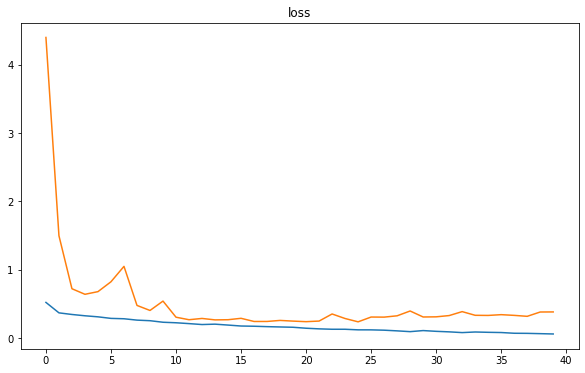

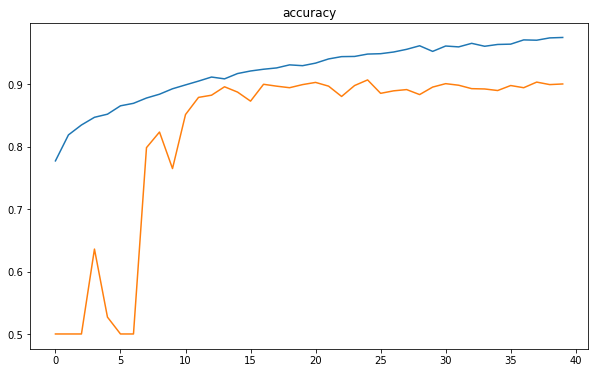

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.35),

    keras.layers.Conv2D(filters=128, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.35),

    keras.layers.Conv2D(filters=512, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=[3,3], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.35),

    keras.layers.Flatten(),

    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.3),

    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=15),
    keras.callbacks.ModelCheckpoint("cnn_06.h5", save_best_only=True),
]

history = model.fit(X_train_06, y_train_06, shuffle=True, epochs=500, validation_data = (X_valid_06, y_valid_06), verbose = 2, steps_per_epoch=X_train_06.shape[0] // 256, callbacks=callbacks)

model.summary()

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_06, y_test_06, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### CNN6 Load

In [24]:
cnn_06 = tf.keras.models.load_model('cnn_06.h5')

In [25]:
cnn_06.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           multiple                  320       
_________________________________________________________________
batch_normalization_8 (Batch multiple                  128       
_________________________________________________________________
conv2d_11 (Conv2D)           multiple                  9248      
_________________________________________________________________
batch_normalization_9 (Batch multiple                  128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_12 (Conv2D)           multiple                 

## Models Evaluation

In [30]:
def correct_predictions(predictions, bool_predictions):
    '''
    identification of probably misclassified samples and correction through CNN06
    '''

    to_class = [] #list of indexes

    for i in range(len(predictions)):
        if predictions[i,0] > 0.5 and predictions[i,6] > 0.35:
            to_class.append(i)

    test_to_class = X_test_copy[to_class,:] 
    test_to_class=tf.expand_dims(test_to_class,3) #for cnn
    cnn_06_pred = cnn_06.predict(test_to_class) #use the binary classifier for the uncertain samples
    cnn_06_pred_bool = []

    for i in range(len(cnn_06_pred)):
        if cnn_06_pred[i] < 0.9:
            cnn_06_pred_bool.append(0) #t-shirt/top
        
        else:
            cnn_06_pred_bool.append(6) #shirt 

    predictions_2 = bool_predictions.copy()

    for i in range(len(to_class)):
        predictions_2[to_class[i]] = cnn_06_pred_bool[i]  

    return predictions_2  

In [31]:
def visual_misclassified(predictions):
    '''
    visual representation of misclassified samples
    '''
    
    dict_wrongs_test = {}

    for i in range(len(predictions)):
        if predictions[i] != y_test[i]:
            dict_wrongs_test[i] = {predictions[i], y_test[i]}


    count_test = {}

    for couple in dict_wrongs_test.values():
        if str(couple) not in count_test.keys():
            count_test[str(couple)] = 1
        else:
            count_test[str(couple)] += 1


    plt.figure(figsize=(15,5))
    plt.bar(count_test.keys(), count_test.values(), width=.5, color='g')

    plt.savefig('misclassified_test.png')

In [32]:
#initial prediction of the CNN10 model

y_pred = cnn_10.predict(X_test)
y_pred_bool = [np.argmax(i) for i in y_pred]

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       1.00      0.99      0.99      1000
           2       0.92      0.90      0.91      1000
           3       0.94      0.94      0.94      1000
           4       0.92      0.92      0.92      1000
           5       0.99      0.99      0.99      1000
           6       0.83      0.84      0.83      1000
           7       0.97      0.98      0.98      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [33]:
#identification of probably misclassified samples and correction through CNN06
y_pred_bool_2 = correct_predictions(y_pred, y_pred_bool)

#new classification accuracy
print(classification_report(y_test, y_pred_bool_2))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       1.00      0.99      0.99      1000
           2       0.92      0.90      0.91      1000
           3       0.94      0.94      0.94      1000
           4       0.92      0.92      0.92      1000
           5       0.99      0.99      0.99      1000
           6       0.83      0.84      0.83      1000
           7       0.97      0.98      0.98      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



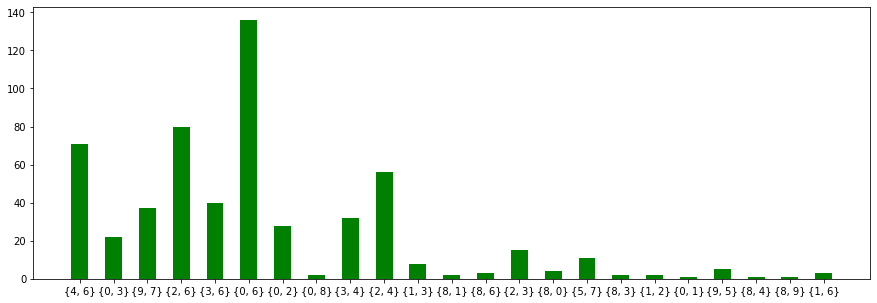

In [34]:
visual_misclassified(y_pred_bool_2)

Now once the new predictions are computed, joining the predictions of CNN10 and CNN06 the final accuracy is:

In [37]:
accuracy = 0

for i in range(len(y_test)):
    if y_test[i] == y_pred_bool_2[i]:
        accuracy += 1

print('accuracy: ' + str(accuracy * 100 / len(y_test)) + '%')

accuracy: 94.38%
